In [1]:
import numpy # pandas library requires newer version of numpy, so to add it in requirements.txt
import pandas as pd

weather = pd.read_csv("data/chennai-temp-rains.csv", index_col="Date")

<AxesSubplot:xlabel='Date'>

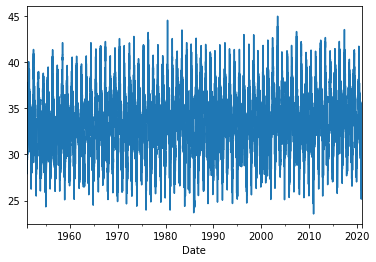

In [2]:
null_pct = weather.apply(pd.isnull).sum()/weather.shape[0]
valid_columns = weather.columns[null_pct < .05]
weather = weather[valid_columns].copy()
weather.columns = weather.columns.str.lower()
weather = weather.ffill()
weather.apply(pd.isnull).sum()
weather.apply(lambda x: (x == 9999).sum())
weather.index = pd.to_datetime(weather.index)
weather.index.year.value_counts().sort_index()
weather["temp_max"].plot()

In [3]:
weather["target"] = weather.shift(-1)["temp_max"]
weather = weather.ffill()
weather["target"]

Date
1951-01-01    28.500000
1951-01-02    28.670000
1951-01-03    28.559999
1951-01-04    28.620001
1951-01-05    28.219999
                ...    
2020-12-27    30.177988
2020-12-28    28.919069
2020-12-29    29.509903
2020-12-30    29.512501
2020-12-31    29.512501
Name: target, Length: 25568, dtype: float64

In [4]:
from sklearn.linear_model import Ridge

rr = Ridge(alpha=.1)

predictors = weather.columns[~weather.columns.isin(["target"])]

def backtest(weather, model, predictors, start=3650, step=90):
    all_predictions = []
    
    for i in range(start, weather.shape[0], step):
        train = weather.iloc[:i,:]
        test = weather.iloc[i:(i+step),:]

        model.fit(train[predictors], train["target"])
        
        preds = model.predict(test[predictors])
        preds = pd.Series(preds, index=test.index)
        combined = pd.concat([test["target"], preds], axis=1)
        combined.columns = ["actual", "prediction"]
        combined["diff"] = (combined["prediction"] - combined["actual"]).abs()
        
        all_predictions.append(combined)
    return pd.concat(all_predictions)


predictions = backtest(weather, rr, predictors)

In [5]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mean_absolute_error(predictions["actual"], predictions["prediction"])

predictions.sort_values("diff", ascending=False)
pd.Series(rr.coef_, index=predictors)

temp_max    0.883645
temp_min    0.103929
dtype: float64

In [6]:
def pct_diff(old, new):
    return (new - old) / old

def compute_rolling(weather, horizon, col):
    label = f"rolling_{horizon}_{col}"
    weather[label] = weather[col].rolling(horizon).mean()
    weather[f"{label}_pct"] = pct_diff(weather[label], weather[col])
    return weather
    
rolling_horizons = [3, 14]
for horizon in rolling_horizons:
    for col in ["temp_max", "temp_min"]:
        weather = compute_rolling(weather, horizon, col)

def expand_mean(df):
    return df.expanding(1).mean()

for col in ["temp_max", "temp_min"]:
    weather[f"month_avg_{col}"] = weather[col].groupby(weather.index.month, group_keys=False).apply(expand_mean)
    weather[f"day_avg_{col}"] = weather[col].groupby(weather.index.day_of_year, group_keys=False).apply(expand_mean)

<AxesSubplot:>

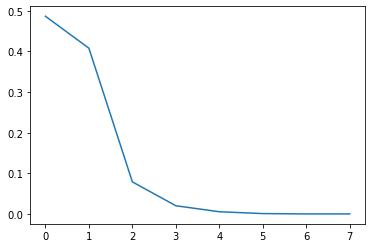

In [7]:
weather = weather.iloc[14:,:]
weather = weather.fillna(0)
predictors = weather.columns[~weather.columns.isin(["target"])]
predictions = backtest(weather, rr, predictors)
mean_absolute_error(predictions["actual"], predictions["prediction"])
mean_squared_error(predictions["actual"], predictions["prediction"])
predictions.sort_values("diff", ascending=False)
weather.loc["1990-03-07": "1990-03-17"]
(predictions["diff"].round().value_counts().sort_index() / predictions.shape[0]).plot()

<AxesSubplot:xlabel='Date'>

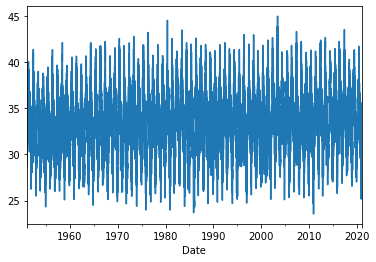

In [8]:
weather["target"].plot()

In [9]:
mean_squared_error(predictions["actual"], predictions["prediction"], squared=False)

0.9741280889350789

In [10]:
predictions

,actual,prediction,diff
Date,,,
1961-01-12,28.650000,28.033810,0.616189
1961-01-13,28.660000,28.824150,0.164150
1961-01-14,28.160000,28.622424,0.462424
1961-01-15,27.860001,28.364210,0.504209
1961-01-16,28.610001,28.279654,0.330347
...,...,...,...
2020-12-27,30.177988,29.708421,0.469567
2020-12-28,28.919069,29.976048,1.056979
2020-12-29,29.509903,29.065332,0.444571


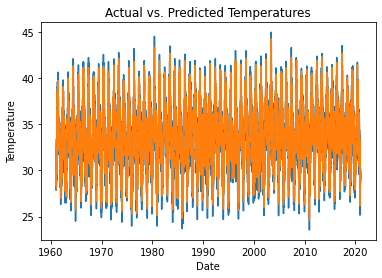

In [11]:
# show the graph of the predictions with the actuals
import matplotlib.pyplot as plt
plt.plot(predictions["actual"])
plt.plot(predictions["prediction"])
# stretch this graph to make it larger
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.title("Actual vs. Predicted Temperatures")
plt.show()


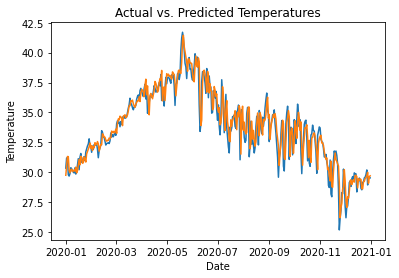

In [12]:
plt.plot(predictions["actual"]["2020"])
plt.plot(predictions["prediction"]["2020"])
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.title("Actual vs. Predicted Temperatures")
plt.show()